In [12]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, adjusted_rand_score , calinski_harabasz_score

import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


# **Helper Functions for DBSCAN Analysis**

In [8]:
def find_optimal_eps(X, k=4, plot=True):
    """
    Find optimal epsilon using k-distance graph method.
    
    Parameters:
    -----------
    X : array-like
        Input data
    k : int, default=4
        Number of nearest neighbors to consider
    plot : bool, default=True
        Whether to plot the k-distance graph
    
    Returns:
    --------
    float : Recommended epsilon value
    """
    # Calculate k-nearest neighbors
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors.fit(X)
    distances, indices = neighbors.kneighbors(X)
    
    # Sort distances to k-th neighbor
    k_distances = distances[:, k-1]
    k_distances = np.sort(k_distances)
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(k_distances)), k_distances, 'b-', linewidth=2)
        plt.xlabel(f'Points sorted by {k}-NN distance')
        plt.ylabel(f'{k}-NN Distance')
        plt.title(f'K-Distance Graph (k={k})\nLook for the "elbow" point')
        plt.grid(True, alpha=0.3)
        
        # Add some guidance lines
        knee_point = int(len(k_distances) * 0.1)  # Rough estimate
        recommended_eps = k_distances[knee_point]
        plt.axhline(y=recommended_eps, color='red', linestyle='--', label=f'Suggested ε ≈ {recommended_eps:.3f}')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        return recommended_eps
    
    return k_distances

def dbscan_analysis(X, eps_range=None, min_samples_range=None, feature_names=None):
    """
    Comprehensive DBSCAN parameter analysis.
    
    Parameters:
    -----------
    X : array-like
        Input data
    eps_range : list, optional
        Range of epsilon values to test
    min_samples_range : list, optional
        Range of min_samples values to test
    feature_names : list, optional
        Names of features for plotting
    
    Returns:
    --------
    dict : Analysis results
    """
    if eps_range is None:
        # Auto-determine eps range based on k-distance
        k_distances = find_optimal_eps(X, plot=False)
        eps_range = np.linspace(k_distances.min(), k_distances.max(), 20)
    
    if min_samples_range is None:
        min_samples_range = range(2, min(20, len(X)//10))
    
    results = []
    
    for eps in eps_range:
        for min_samples in min_samples_range:
            # Fit DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            # Calculate metrics
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            
            # Silhouette score (only if we have valid clusters)
            if n_clusters > 1 and n_noise < len(labels):
                sil_score = silhouette_score(X, labels)
            else:
                sil_score = -1
            
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'noise_ratio': n_noise / len(X),
                'silhouette': sil_score
            })
    
    return pd.DataFrame(results)

def plot_dbscan_results(X, labels, eps, min_samples, feature_names=None, title_suffix=""):
    """
    Plot DBSCAN clustering results.
    
    Parameters:
    -----------
    X : array-like
        Input data
    labels : array-like
        Cluster labels from DBSCAN
    eps : float
        Epsilon parameter used
    min_samples : int
        Min samples parameter used
    feature_names : list, optional
        Names of features for plotting
    title_suffix : str, optional
        Additional text for plot title
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Prepare data
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    unique_labels = set(labels)
    
    # Create colors for plotting
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    # Plot 1: Cluster visualization (first two features)
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Noise points
            col = 'black'
            marker = 'x'
            alpha = 0.5
            label = f'Noise ({n_noise} points)'
        else:
            marker = 'o'
            alpha = 0.8
            label = f'Cluster {k}'
        
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        axes[0, 0].scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, alpha=alpha, s=60, label=label)
    
    axes[0, 0].set_title(f'DBSCAN Clustering Results {title_suffix}\nε={eps:.3f}, MinPts={min_samples}', fontweight='bold', fontsize=14)
    axes[0, 0].set_xlabel(feature_names[0] if feature_names else 'Feature 1')
    axes[0, 0].set_ylabel(feature_names[1] if feature_names else 'Feature 2')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0, 0].grid(alpha=0.3)
    
    # Plot 2: Cluster statistics
    cluster_stats = pd.Series(labels).value_counts().sort_index()
    noise_count = cluster_stats.get(-1, 0)
    cluster_counts = cluster_stats.drop(-1, errors='ignore')
    
    bars = axes[0, 1].bar(range(len(cluster_counts)), cluster_counts.values,  color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'][:len(cluster_counts)], alpha=0.8)
    
    if noise_count > 0:
        axes[0, 1].bar(len(cluster_counts), noise_count, color='black', alpha=0.6, label='Noise')
    
    axes[0, 1].set_title('Cluster Sizes', fontweight='bold', fontsize=14)
    axes[0, 1].set_xlabel('Cluster ID')
    axes[0, 1].set_ylabel('Number of Points')
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    all_bars = list(bars) + ([axes[0, 1].patches[-1]] if noise_count > 0 else [])
    all_values = list(cluster_counts.values) + ([noise_count] if noise_count > 0 else [])
    
    for bar, count in zip(all_bars, all_values):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(all_values)*0.01,str(count), ha='center', va='bottom', fontweight='bold')
    
    # Plot 3: Parameter sensitivity heatmap (if 2D data)
    if X.shape[1] == 2:
        # Show epsilon circles around sample points
        sample_indices = np.random.choice(len(X), min(10, len(X)), replace=False)
        for idx in sample_indices:
            circle = plt.Circle((X[idx, 0], X[idx, 1]), eps, fill=False, color='gray', alpha=0.3, linestyle='--')
            axes[1, 0].add_patch(circle)
        
        # Plot points again
        for k, col in zip(unique_labels, colors):
            if k == -1:
                col = 'black'
                marker = 'x'
                alpha = 0.5
            else:
                marker = 'o'
                alpha = 0.8
            
            class_member_mask = (labels == k)
            xy = X[class_member_mask]
            axes[1, 0].scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, alpha=alpha, s=60)
        
        axes[1, 0].set_title(f'ε-neighborhoods (ε={eps:.3f})', fontweight='bold', fontsize=14)
        axes[1, 0].set_xlabel(feature_names[0] if feature_names else 'Feature 1')
        axes[1, 0].set_ylabel(feature_names[1] if feature_names else 'Feature 2')
        axes[1, 0].set_aspect('equal', adjustable='box')
        axes[1, 0].grid(alpha=0.3)
    
    # Plot 4: Cluster quality metrics
    metrics_names = ['Clusters', 'Noise Points', 'Noise %']
    metrics_values = [n_clusters, n_noise, (n_noise/len(X)*100)]
    colors_metrics = ['#2e7d32', '#f57c00', '#d32f2f']
    
    bars = axes[1, 1].bar(metrics_names, metrics_values, color=colors_metrics, alpha=0.8)
    axes[1, 1].set_title('Clustering Metrics', fontweight='bold', fontsize=14)
    axes[1, 1].set_ylabel('Count / Percentage')
    
    # Add value labels
    for bar, metric_name, value in zip(bars, metrics_names, metrics_values):
        label = f'{value:.1f}%' if 'Noise %' in metric_name else f'{int(value)}'
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(metrics_values)*0.01, label, ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_ratio': n_noise / len(X),
        'labels': labels
    }

print("✅ Helper functions defined successfully!")
print("🔧 Ready to perform DBSCAN analysis")

✅ Helper functions defined successfully!
🔧 Ready to perform DBSCAN analysis


## 🎯 **Example 1: Non-Spherical Clusters (Moons Dataset)**

🌙 Generating Two Moons Dataset...
📊 Dataset shape: (300, 2)
🎯 True clusters: 2


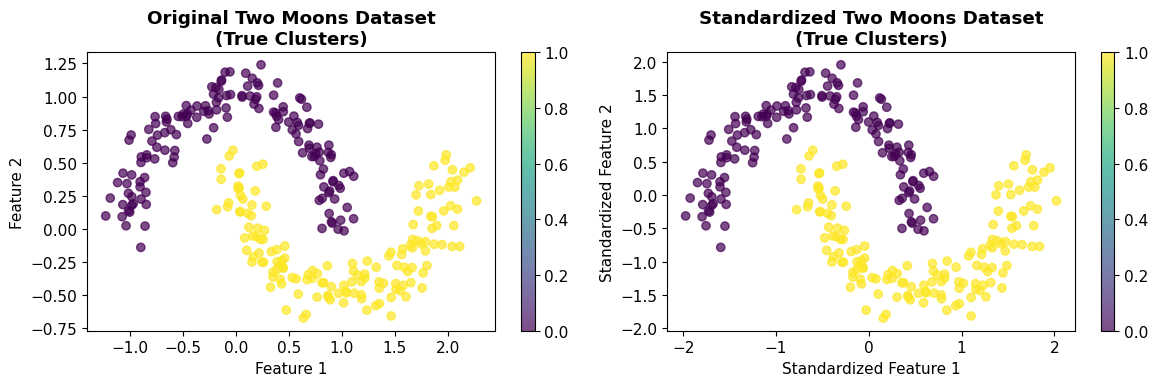

In [9]:
# Generate non-spherical data (Two Moons)
print("🌙 Generating Two Moons Dataset...")
X_moons, y_true_moons = make_moons(n_samples=300, noise=0.1, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_moons_scaled = scaler.fit_transform(X_moons)

print(f"📊 Dataset shape: {X_moons.shape}")
print(f"🎯 True clusters: {len(np.unique(y_true_moons))}")

# Plot original data
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_true_moons, cmap='viridis', alpha=0.7)
plt.title('Original Two Moons Dataset\n(True Clusters)', fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(X_moons_scaled[:, 0], X_moons_scaled[:, 1], c=y_true_moons, cmap='viridis', alpha=0.7)
plt.title('Standardized Two Moons Dataset\n(True Clusters)', fontweight='bold')
plt.xlabel('Standardized Feature 1')
plt.ylabel('Standardized Feature 2')
plt.colorbar()

plt.tight_layout()
plt.show()

🔍 Finding optimal epsilon...


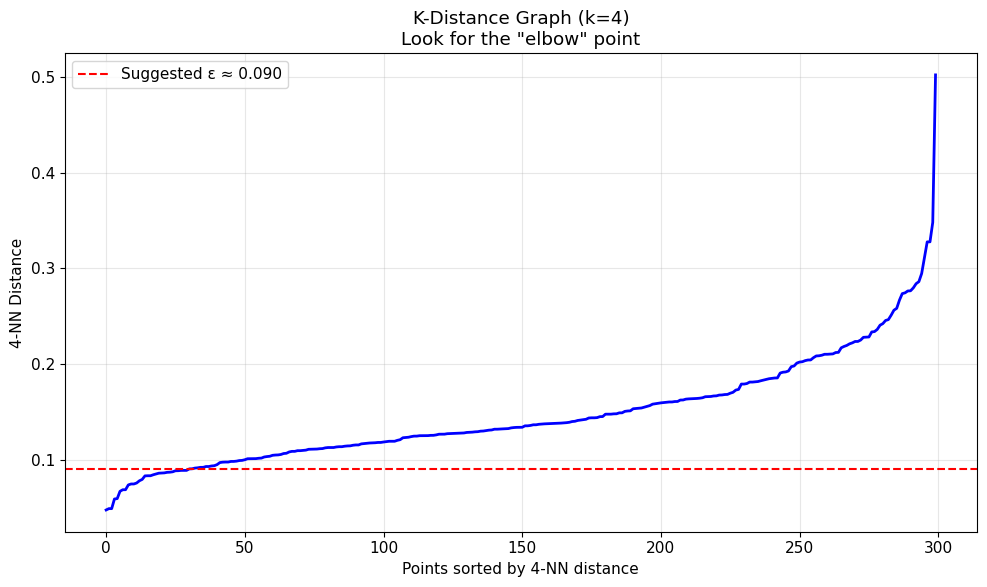


⚙️ Applying DBSCAN with ε=0.090, MinPts=4


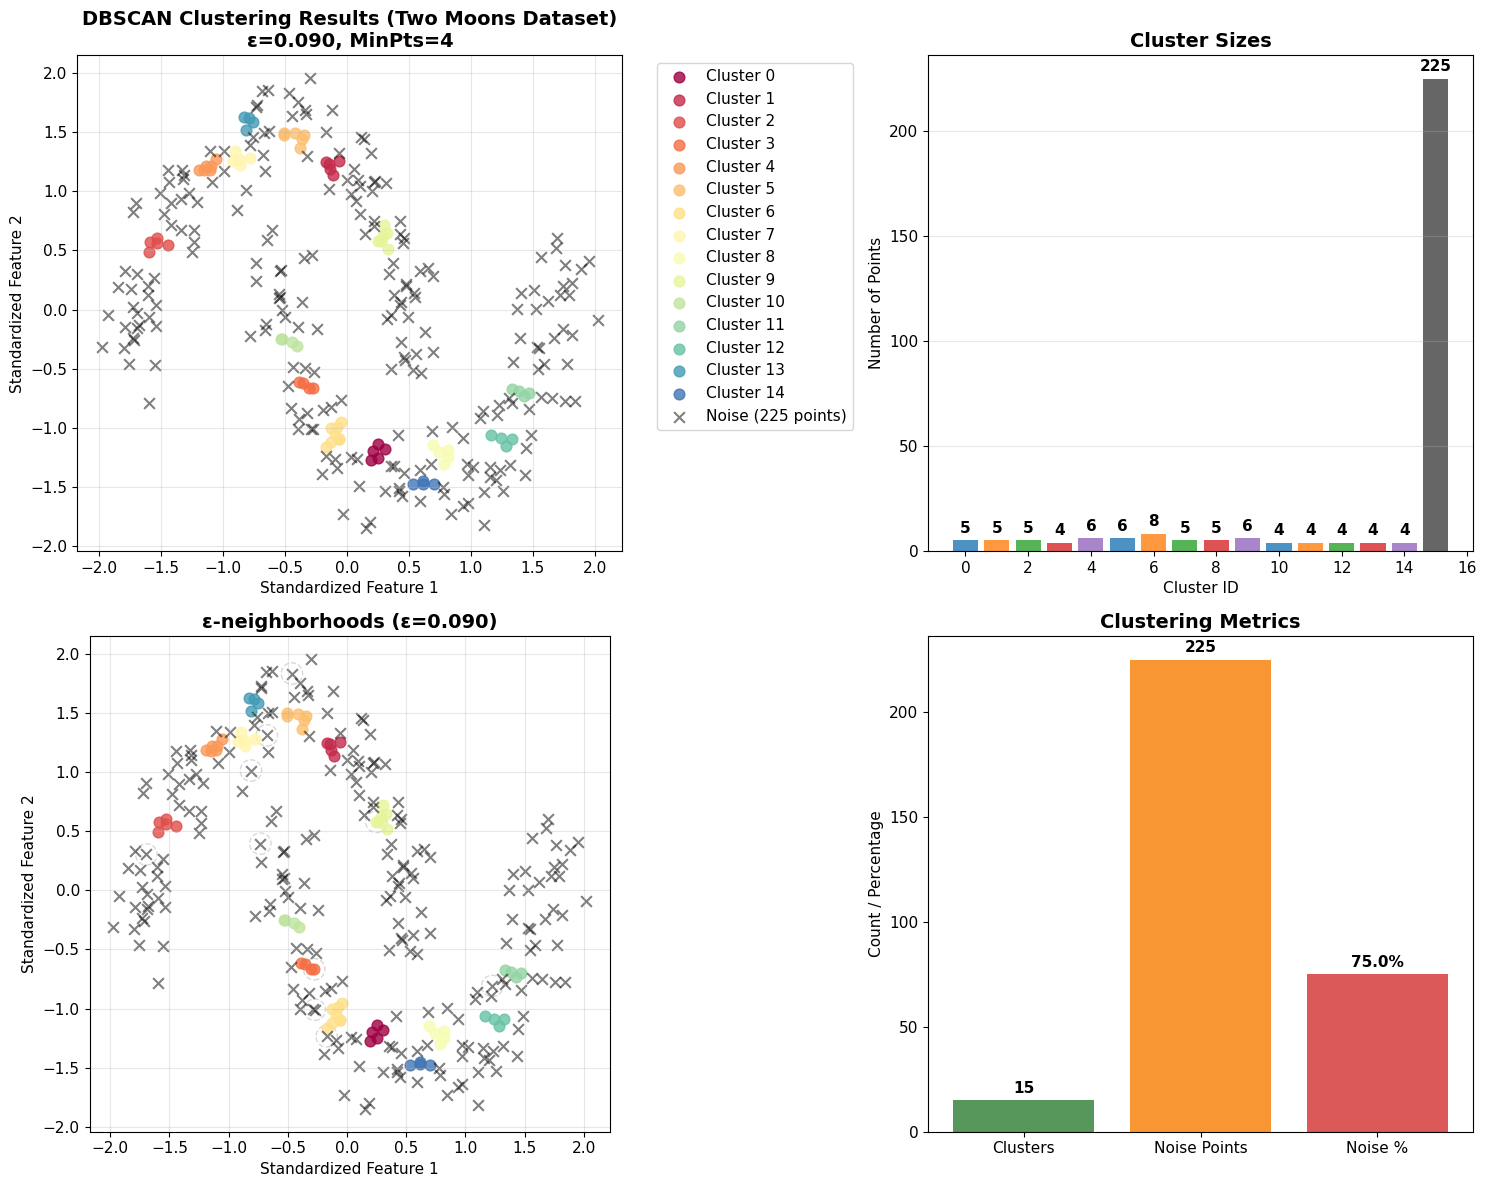


📊 DBSCAN Results:
   🎯 Clusters found   : 15
   🚮 Noise points     : 225
   📈 Noise ratio      : 75.0%
   📊 Silhouette Score : -0.389


In [11]:
# Step 1: Find optimal epsilon using k-distance graph
print("🔍 Finding optimal epsilon...")
optimal_eps = find_optimal_eps(X_moons_scaled, k=4)

# Step 2: Apply DBSCAN with optimal parameters
print(f"\n⚙️ Applying DBSCAN with ε={optimal_eps:.3f}, MinPts=4")
dbscan_moons = DBSCAN(eps=optimal_eps, min_samples=4)
labels_moons = dbscan_moons.fit_predict(X_moons_scaled)

# Step 3: Analyze and visualize results
results_moons = plot_dbscan_results(X_moons_scaled, labels_moons, optimal_eps, 4,  feature_names=['Standardized Feature 1', 'Standardized Feature 2'],  title_suffix="(Two Moons Dataset)")

print(f"\n📊 DBSCAN Results:")
print(f"   🎯 Clusters found   : {results_moons['n_clusters']}")
print(f"   🚮 Noise points     : {results_moons['n_noise']}")
print(f"   📈 Noise ratio      : {results_moons['noise_ratio']:.1%}")

# Compare with true labels if available
if len(np.unique(y_true_moons)) == results_moons['n_clusters']:
    ari_score = adjusted_rand_score(y_true_moons, labels_moons)
    print(f"   🎯 Adjusted Rand Index: {ari_score:.3f}")
    
if results_moons['n_clusters'] > 1:
    sil_score = silhouette_score(X_moons_scaled, labels_moons)
    print(f"   📊 Silhouette Score : {sil_score:.3f}")

<h1 align="center"> <strong>📊 Evaluation Techniques</strong> </h1>

## 🎯 **DBSCAN-Specific Evaluation Metrics**

DBSCAN presents unique evaluation challenges since it identifies noise points and doesn't require pre-specifying cluster count.

In [13]:
# Comprehensive evaluation function for DBSCAN
def evaluate_dbscan_comprehensive(X, labels, eps, min_samples, true_labels=None):
    """
    Comprehensive evaluation of DBSCAN results.
    
    Parameters:
    -----------
    X : array-like
        Input data
    labels : array-like
        DBSCAN cluster labels
    eps : float
        Epsilon parameter used
    min_samples : int
        Min samples parameter used
    true_labels : array-like, optional
        Ground truth labels for external validation
    
    Returns:
    --------
    dict : Evaluation metrics
    """
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    n_points = len(labels)
    
    metrics = {
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'noise_ratio': n_noise / n_points,
        'parameters': {'eps': eps, 'min_samples': min_samples}
    }
    
    # Internal metrics (if we have valid clusters)
    if n_clusters > 1 and n_noise < n_points:
        # Silhouette score (excluding noise points)
        valid_mask = labels != -1
        if np.sum(valid_mask) > 0:
            metrics['silhouette_score'] = silhouette_score(X[valid_mask], labels[valid_mask])
        
        # Calinski-Harabasz score
        if np.sum(valid_mask) > 0:
            metrics['calinski_harabasz'] = calinski_harabasz_score(X[valid_mask], labels[valid_mask])
    
    # External metrics (if true labels available)
    if true_labels is not None:
        from sklearn.metrics import (adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score)
        
        metrics['adjusted_rand_index'] = adjusted_rand_score(true_labels, labels)
        metrics['normalized_mutual_info'] = normalized_mutual_info_score(true_labels, labels)
        metrics['homogeneity'] = homogeneity_score(true_labels, labels)
        metrics['completeness'] = completeness_score(true_labels, labels)
        metrics['v_measure'] = v_measure_score(true_labels, labels)
    
    return metrics

# Demonstrate comprehensive evaluation
print("📊 Comprehensive DBSCAN Evaluation")
print("=" * 50)

evaluation = evaluate_dbscan_comprehensive(X_moons_scaled, labels_moons, optimal_eps, 4, y_true_moons)

print(f"🔧 Parameters:")
print(f"   ε (eps) : {evaluation['parameters']['eps']:.4f}")
print(f"   MinPts  : {evaluation['parameters']['min_samples']}")

print(f"\n📈 Clustering Results:")
print(f"   Clusters found : {evaluation['n_clusters']}")
print(f"   Noise points   : {evaluation['n_noise']}")
print(f"   Noise ratio    : {evaluation['noise_ratio']:.1%}")

if 'silhouette_score' in evaluation:
    print(f"\n📊 Internal Validation:")
    print(f"   Silhouette Score  : {evaluation['silhouette_score']:.4f}")
    print(f"   Calinski-Harabasz : {evaluation['calinski_harabasz']:.2f}")

if 'adjusted_rand_index' in evaluation:
    print(f"\n🎯 External Validation:")
    print(f"   Adjusted Rand Index    : {evaluation['adjusted_rand_index']:.4f}")
    print(f"   Normalized Mutual Info : {evaluation['normalized_mutual_info']:.4f}")
    print(f"   V-measure: {evaluation['v_measure']:.4f}")

print(f"\n💡 Interpretation:")
if evaluation['n_clusters'] >= 2:
    print("   ✅ Successfully identified multiple clusters")
else:
    print("   ⚠️ Only one or no clusters found - consider adjusting parameters")

if evaluation['noise_ratio'] < 0.1:
    print("   ✅ Low noise ratio - good cluster separation")
elif evaluation['noise_ratio'] < 0.2:
    print("   ⚠️ Moderate noise ratio - acceptable for most applications")
else:
    print("   ❌ High noise ratio - may need parameter adjustment")

📊 Comprehensive DBSCAN Evaluation
🔧 Parameters:
   ε (eps) : 0.0903
   MinPts  : 4

📈 Clustering Results:
   Clusters found : 15
   Noise points   : 225
   Noise ratio    : 75.0%

📊 Internal Validation:
   Silhouette Score  : 0.7467
   Calinski-Harabasz : 1870.33

🎯 External Validation:
   Adjusted Rand Index    : 0.0059
   Normalized Mutual Info : 0.1799
   V-measure: 0.1799

💡 Interpretation:
   ✅ Successfully identified multiple clusters
   ❌ High noise ratio - may need parameter adjustment


# 🧠 Project Insight

## 🎯 **When to Choose DBSCAN Over Other Algorithms**

<div style="background: #fff3e0; padding: 15px; border-left: 4px solid #ff9800; margin: 15px 0; color: #333;">
<strong>✅ Choose DBSCAN When:</strong>
<ul>
<li><strong>Unknown cluster count:</strong> You don't know how many clusters to expect</li>
<li><strong>Arbitrary shapes:</strong> Clusters are non-spherical (crescents, donuts, spirals)</li>
<li><strong>Noise handling:</strong> You need to explicitly identify outliers</li>
<li><strong>Density-based clustering:</strong> Natural clusters have different densities</li>
<li><strong>Geographic data:</strong> Spatial clustering with irregular boundaries</li>
</ul>
</div>

<div style="background: #fce4ec; padding: 15px; border-left: 4px solid #e91e63; margin: 15px 0; color: #333;">
<strong>❌ Choose Other Methods When:</strong>
<ul>
<li><strong>Vastly different densities:</strong> Use hierarchical clustering or multi-scale approaches</li>
<li><strong>Large datasets:</strong> Use K-means or mini-batch clustering</li>
<li><strong>High dimensions:</strong> Use dimensionality reduction + clustering</li>
<li><strong>Real-time applications:</strong> Use simpler, faster algorithms</li>
<li><strong>Spherical clusters:</strong> K-means is more efficient</li>
</ul>
</div>

---

## 🔧 **Production Deployment Guidelines**

### **1. Parameter Selection Strategy**
```python
# Recommended parameter selection workflow:
1. Use k-distance graph to estimate epsilon
2. Start with MinPts = 2 × dimensions
3. Validate with silhouette analysis
4. Adjust based on domain knowledge
```

### **2. Preprocessing Pipeline**
```python
# Essential preprocessing steps:
1. Handle missing values (imputation or removal)
2. Scale features (StandardScaler recommended)
3. Remove or handle extreme outliers
4. Consider dimensionality reduction if high-D
```

### **3. Performance Optimization**
- **Memory management**: Use sparse matrices for large datasets
- **Parallelization**: Utilize sklearn's n_jobs parameter
- **Approximation**: Consider OPTICS for varying densities
- **Incremental processing**: Split large datasets into chunks

### **4. Model Validation**
- **Cross-validation**: Use repeated random subsampling
- **Stability analysis**: Test parameter sensitivity
- **Domain validation**: Verify clusters make business sense
- **Visual inspection**: Always plot results when possible

---

## 🚨 **Common Pitfalls and Solutions**

### **1. 📏 Feature Scaling Issues**
```python
# Problem: Different feature scales dominate distance calculations
# Solution: Always standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
```

### **2. 🎛️ Parameter Sensitivity**
```python
# Problem: Results vary dramatically with small parameter changes
# Solution: Systematic parameter grid search
eps_range = np.linspace(0.1, 2.0, 20)
min_samples_range = range(2, 20)
# Test multiple combinations and use validation metrics
```

### **3. 🏔️ Curse of Dimensionality**
```python
# Problem: Distance becomes meaningless in high dimensions
# Solution: Apply dimensionality reduction first
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_reduced = pca.fit_transform(X_scaled)
```

### **4. 🔍 Density Variation Handling**
```python
# Problem: Clusters with very different densities
# Solution: Use OPTICS algorithm or multi-scale approaches
from sklearn.cluster import OPTICS
optics = OPTICS(min_samples=5, xi=0.05)
```

---

# 🔁 Reusability

## 📦 **Reusable DBSCAN Pipeline Class**

🚀 Testing Reusable DBSCAN Pipeline
📊 Pipeline Results:
   Clusters     : 15
   Noise points : 225
   Parameters   : ε=0.0903, MinPts=4


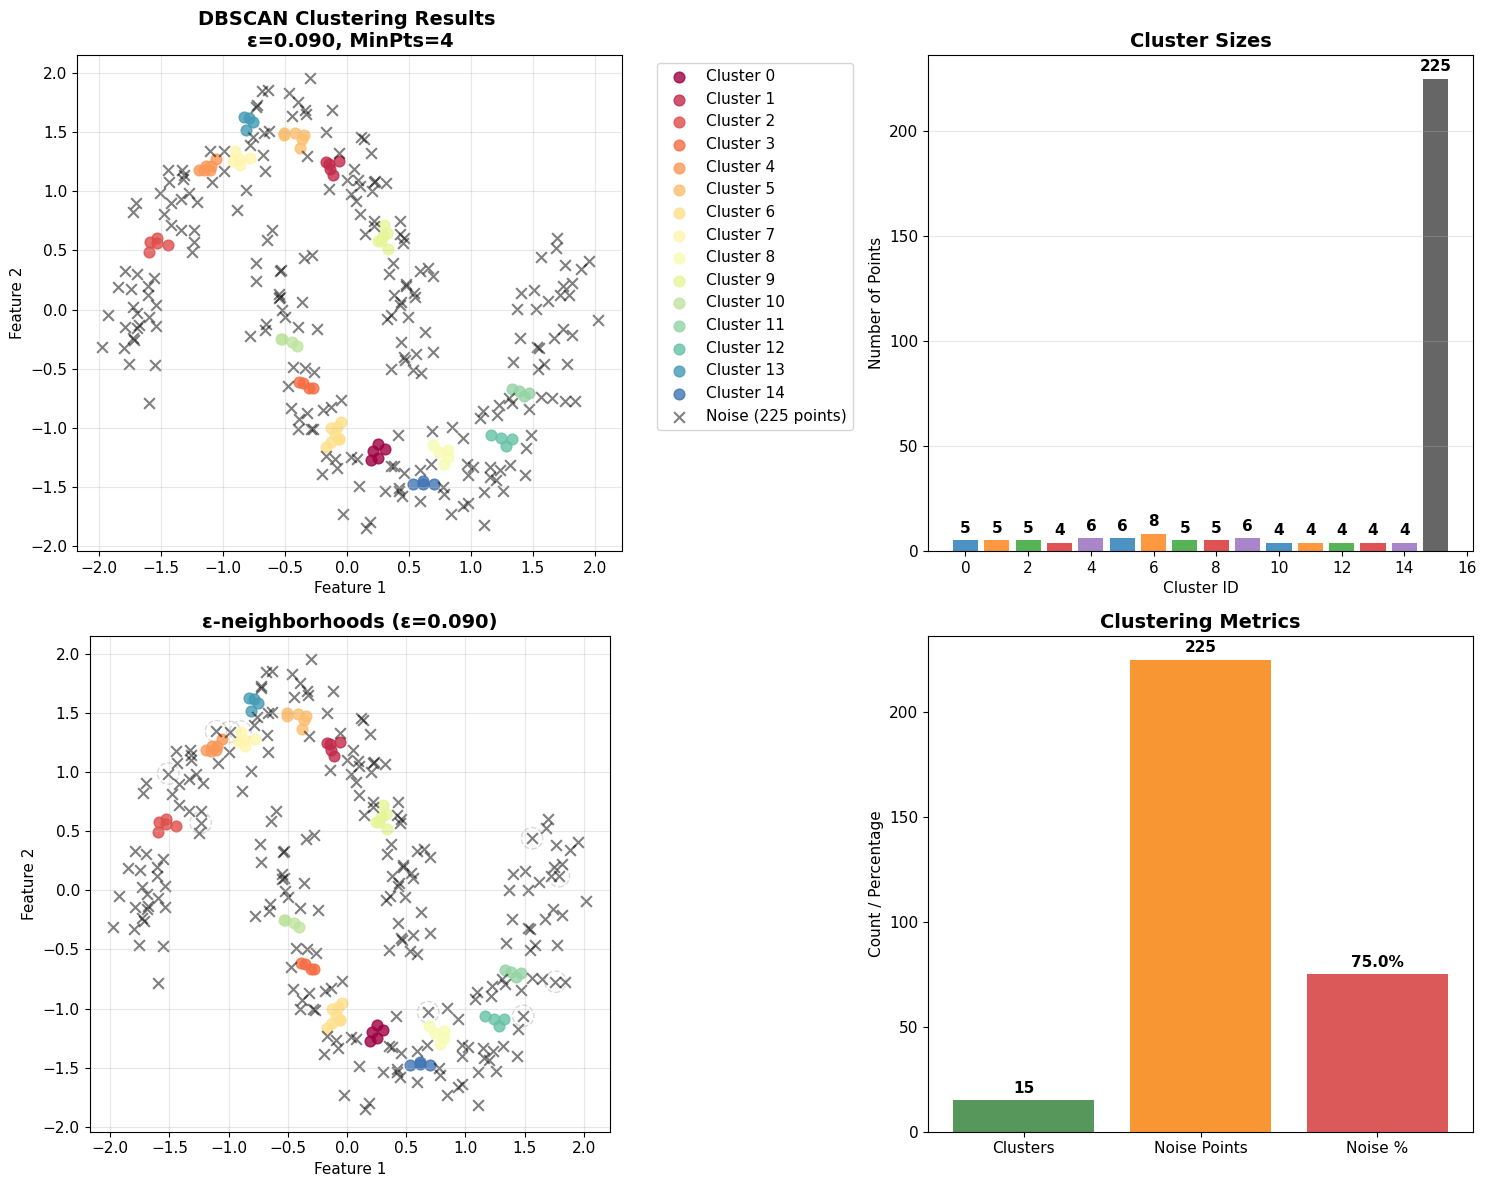


✅ DBSCAN Pipeline ready for production use!
📋 Usage   : pipeline = DBSCANPipeline().fit(your_data)
📊 Results : results = pipeline.get_results()


In [14]:
class DBSCANPipeline:
    """
    Reusable DBSCAN clustering pipeline with automatic parameter optimization.
    """
    
    def __init__(self, scale_features=True, optimize_params=True):
        self.scale_features  = scale_features
        self.optimize_params = optimize_params
        self.scaler          = None
        self.model           = None
        self.best_params     = None
        self.labels_         = None
        
    def _find_optimal_eps(self, X, k=4):
        """Find optimal epsilon using k-distance method."""
        neighbors = NearestNeighbors(n_neighbors=k)
        neighbors.fit(X)
        distances, _ = neighbors.kneighbors(X)
        k_distances = np.sort(distances[:, k-1])
        
        # Find elbow point (simplified)
        knee_point = int(len(k_distances) * 0.1)
        return k_distances[knee_point]
    
    def fit(self, X, eps=None, min_samples=None):
        """
        Fit DBSCAN model to data.
        
        Parameters:
        -----------
        X : array-like
            Input data
        eps : float, optional
            Epsilon parameter. If None, will be optimized.
        min_samples : int, optional
            Minimum samples parameter. If None, uses 2*n_features.
        
        Returns:
        --------
        self : DBSCANPipeline
        """
        X = np.array(X)
        
        # Feature scaling
        if self.scale_features:
            self.scaler = StandardScaler()
            X_processed = self.scaler.fit_transform(X)
        else:
            X_processed = X.copy()
        
        # Parameter optimization
        if self.optimize_params:
            if eps is None:
                eps = self._find_optimal_eps(X_processed)
            if min_samples is None:
                min_samples = max(2, 2 * X.shape[1])
        else:
            eps = eps or 0.5
            min_samples = min_samples or 5
        
        # Store best parameters
        self.best_params = {'eps': eps, 'min_samples': min_samples}
        
        # Fit DBSCAN
        self.model = DBSCAN(eps=eps, min_samples=min_samples)
        self.labels_ = self.model.fit_predict(X_processed)
        
        return self
    
    def get_results(self):
        """Get clustering results and metrics."""
        if self.labels_ is None:
            raise ValueError("Model has not been fitted yet.")
        
        n_clusters = len(set(self.labels_)) - (1 if -1 in self.labels_ else 0)
        n_noise = list(self.labels_).count(-1)
        
        return {
            'labels': self.labels_,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_ratio': n_noise / len(self.labels_),
            'parameters': self.best_params
        }
    
    def plot_results(self, X, feature_names=None, figsize=(15, 10)):
        """Plot clustering results."""
        if self.labels_ is None:
            raise ValueError("Model has not been fitted yet.")
        
        # Use processed data for plotting
        if self.scaler is not None:
            X_plot = self.scaler.transform(X)
        else:
            X_plot = X
        
        return plot_dbscan_results(
            X_plot, self.labels_, 
            self.best_params['eps'], self.best_params['min_samples'],
            feature_names
        )

# Demonstrate the reusable pipeline
print("🚀 Testing Reusable DBSCAN Pipeline")
print("=" * 40)

# Create and fit pipeline
pipeline = DBSCANPipeline(scale_features=True, optimize_params=True)
pipeline.fit(X_moons)

# Get results
results = pipeline.get_results()
print(f"📊 Pipeline Results:")
print(f"   Clusters     : {results['n_clusters']}")
print(f"   Noise points : {results['n_noise']}")
print(f"   Parameters   : ε={results['parameters']['eps']:.4f}, MinPts={results['parameters']['min_samples']}")

# Plot results
pipeline.plot_results(X_moons, ['Feature 1', 'Feature 2'])

print("\n✅ DBSCAN Pipeline ready for production use!")
print("📋 Usage   : pipeline = DBSCANPipeline().fit(your_data)")
print("📊 Results : results = pipeline.get_results()")

## 📋 **Quick Reference Summary**

### **🎯 When to Use DBSCAN:**
- ✅ Unknown number of clusters
- ✅ Non-spherical cluster shapes
- ✅ Need to identify outliers
- ✅ Varying cluster densities
- ✅ Geographic/spatial data

### **⚙️ Key Parameters:**
- **ε (eps)**: Use k-distance graph method
- **MinPts**: Start with 2 × dimensions
- **metric**: Euclidean (default), Manhattan, Cosine

### **📊 Evaluation Metrics:**
- **Internal**: Silhouette score, Calinski-Harabasz
- **External**: Adjusted Rand Index, V-measure
- **Custom**: Noise ratio, cluster balance

### **🚨 Common Issues:**
- Feature scaling required
- Parameter sensitivity
- Curse of dimensionality
- Varying density clusters

---

## 🔗 **Next Steps and Extensions**

### **1. 🔍 Explore Other Density-Based Methods:**
- **OPTICS**: For varying density clusters
- **HDBSCAN**: Hierarchical DBSCAN
- **Mean-shift**: Mode-seeking clustering

### **2. 📊 Advanced Applications:**
- **Anomaly detection**: Use noise points as anomalies
- **Time series clustering**: Apply to sequential data
- **Image segmentation**: Spatial clustering applications
- **Social network analysis**: Community detection

### **3. 🏗️ Integration Projects:**
- **Customer segmentation**: Geographic customer clustering
- **Fraud detection**: Combine with anomaly detection
- **Marketing campaigns**: Location-based targeting
- **Quality control**: Defect pattern analysis

### **📖 Additional Resources:**
- Original DBSCAN paper: Ester et al. (1996)
- OPTICS algorithm for density variations
- HDBSCAN for hierarchical density clustering
- Sklearn documentation and examples

---

<div style="background: #e8f5e8; padding: 20px; border-radius: 10px; text-align: left; margin: 20px 0; color: #333;">
<h3 style="color: #2e7d32; margin-top: 0;">🎉 DBSCAN Mastery Complete!</h3>
<p style="margin: 10px 0;"><strong>You now have a comprehensive understanding of DBSCAN clustering, including:</strong></p>
<ul style="list-style: none; padding: 0;">
<li>✅ Theoretical foundations and mathematical concepts</li>
<li>✅ Practical implementation with parameter optimization</li>
<li>✅ Evaluation techniques and interpretation</li>
<li>✅ Production-ready pipeline for real projects</li>
<li>✅ Common pitfalls and best practices</li>
</ul>
<p><strong>Ready to apply DBSCAN to your own clustering challenges!</strong> 🚀</p>
</div>